In [1]:
## 환경 세팅 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline 

# 경고창 무시
import warnings
warnings.filterwarnings(action='ignore')

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

pd.options.display.float_format = '{:.0f}'.format

import platform
from matplotlib import rc

rc('font', family = 'AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline
        
# seed 설정
np.random.seed(42)

### 데이터 가져오기

In [2]:
data = pd.read_csv('실전db.csv')
trans = pd.read_csv('교통량통합.csv')

## 합쳐주기

In [3]:
data['DATE']=pd.to_datetime(data['DATE'])
trans['DATE'] = pd.to_datetime(trans['DATE'])

ndata = pd.merge(data,trans, how='left', left_on='DATE', right_on='DATE')

In [4]:
ndata['moving'] = ndata.groupby('USER_ID')['STORE_ID'].transform('count')

In [5]:
ndata['parking_area']=ndata['STORE_ID'].astype(str).str[:-3]

In [6]:
ndata['parking_area'].replace('', '0', inplace=True)

In [7]:
ndata['parking_area'].unique()

array(['1', '182', '82', '0', '220', '91', '109', '131', '2', '190',
       '172', '102', '92', '90', '110', '105', '204', '106', '219', '104',
       '203', '27', '181', '93', '96', '157', '207', '137', '108', '173',
       '186', '28', '97', '111', '188', '189', '101', '205', '183', '107',
       '185', '184', '132', '83', '48', '221', '133', '222', '158', '223',
       '136', '225', '227', '228', '67', '229', '230', '68', '231'],
      dtype=object)

In [8]:
ndata['parking_range']=ndata.groupby('USER_ID')['parking_area'].transform('nunique')

In [9]:
from sklearn import preprocessing


le = preprocessing.LabelEncoder()

ndata['D_TYPE'] = le.fit_transform(ndata['D_TYPE'])
ndata['GOODS_TYPE'] = le.fit_transform(ndata['GOODS_TYPE'])
ndata['AD1'] = le.fit_transform(ndata['AD1'])
ndata['parking_area'] = le.fit_transform(ndata['parking_area'])
ndata['parking_range'] = le.fit_transform(ndata['parking_range'])


In [10]:
u_ndata = ndata['USER_ID'].value_counts().to_frame()
u_ndata.reset_index(inplace = True)
u_ndata.columns = ['USER_ID','결제건수']
ndata = pd.merge(ndata, u_ndata, how='left', left_on='USER_ID', right_on='USER_ID')

In [11]:
ndata['Month'] = [k for k in ndata['DATE'].dt.month]
ndata['Day'] = [k for k in ndata['DATE'].dt.day]
ndata['dayofweek'] = [k for k in ndata['DATE'].dt.dayofweek]

In [12]:
# 2020년 holiday 지정
import pandas as pd
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday

class Calendar(AbstractHolidayCalendar):
    rules = [
        Holiday('New Year', month=1, day=1),
        Holiday('KR_New Year1', month=1, day=24),
        Holiday('KR_New Year2', month=1, day=25),
        Holiday('KR_New Year3', month=1, day=26),
        Holiday('3.1', month=3, day=1),
        Holiday('Buddha Day', month=4, day=30),
        Holiday('Memorial Day', month=6, day=6),
        Holiday('Liberation Day', month=8, day=15),
        Holiday('KR_Thanksgiving1', month=9, day=30),
        Holiday('KR_Thanksgiving2', month=10, day=1),
        Holiday('KR_Thanksgiving3', month=10, day=2),
        Holiday('National Foundation Day', month=10, day=3),
        Holiday('Hangul Day', month=10, day=9),
        Holiday('Christmas', month=12, day=25)
    ]
dr = pd.date_range(start='2020-01-01', end='2020-12-31')
cal = Calendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())
ndata['Holiday'] = ndata['DATE'].isin(holidays)

# 일요일도 holiday로
for i in range(len(ndata)):
    if ndata['Day'][i] == 6:
        ndata['Holiday'][i] = True

In [13]:
ndata['Weekend_indi'] = 0
ndata['EveryDay'] = ndata.loc[ndata['Day'].isin([4,5]), 'Weekend_indi'] =1

In [14]:
ndata.drop(['USER_ID','JOIN_DATE','STORE_ID','EveryDay'],axis=1,inplace=True)

In [15]:
# 날짜로 자르기 위해 'DATE'를 인덱스로 설정
ndata.set_index('DATE',inplace=True)

# 데이터 분리
train = ndata.loc[:'2020-09-30']
test = ndata.loc['2020-10-01':]

# 인덱스 리셋 후 'DATE' 컬럼 삭제
train.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)

In [16]:
train_X = train.drop('COUNT',axis=1)
train_y = train[['COUNT']]

test_X = test.drop('COUNT',axis=1)
test_y = test[['COUNT']]

In [17]:
display(train_X, test_X)

,D_TYPE,GOODS_TYPE,AD1,합계,moving,parking_area,parking_range,결제건수,Month,Day,dayofweek,Holiday,Weekend_indi
0,0,0,40,7347299,1,1,0,1,1,1,2,True,0
1,1,0,50,7347299,2,22,1,2,1,1,2,True,0
2,1,0,64,7347299,3,51,1,3,1,1,2,True,0
3,1,2,53,7347299,30,0,11,30,1,1,2,True,0
4,0,2,52,7347299,3,36,2,3,1,1,2,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
623574,1,1,40,7129682,4,37,3,4,9,30,2,True,0
623575,0,1,53,7129682,1,0,0,1,9,30,2,True,0
623576,0,1,4,7129682,1,39,0,1,9,30,2,True,0
623577,1,0,52,7129682,1,22,0,1,9,30,2,True,0


,D_TYPE,GOODS_TYPE,AD1,합계,moving,parking_area,parking_range,결제건수,Month,Day,dayofweek,Holiday,Weekend_indi
0,0,0,52,6879272,1,22,0,1,10,1,3,True,0
1,1,3,50,6879272,2,51,0,2,10,1,3,True,0
2,1,0,52,6879272,2,22,1,2,10,1,3,True,0
3,1,0,22,6879272,10,32,5,10,10,1,3,True,0
4,0,0,65,6879272,2,36,1,2,10,1,3,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
255687,1,1,40,8324393,1,35,0,1,12,31,3,False,0
255688,1,1,19,8324393,1,51,0,1,12,31,3,False,0
255689,0,1,52,8324393,1,55,0,1,12,31,3,False,0
255690,1,1,50,8324393,1,55,0,1,12,31,3,False,0


In [18]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error, mean_absolute_error

# rfr = RandomForestRegressor()
    
# rfr.fit(train_X, train_y)
    
# y_pred = rfr.predict(test_X)

# MSE = mean_squared_error(test_y, y_pred)
# MAE = mean_absolute_error(test_y, y_pred)
# print('MSE :', MSE)
# print('MAE :', MAE)

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from lightgbm import LGBMRegressor

lgbr = LGBMRegressor(n_estimators=400) # 트리 수 지정

lgbr.fit(train_X, train_y)

y_pred2 = lgbr.predict(test_X)

MSE = mean_squared_error(test_y, y_pred2)
MAE = mean_absolute_error(test_y, y_pred2)
print('MSE :', MSE)
print('MAE :', MAE)

MSE : 0.09037748328111311
MAE : 0.04677797946973616


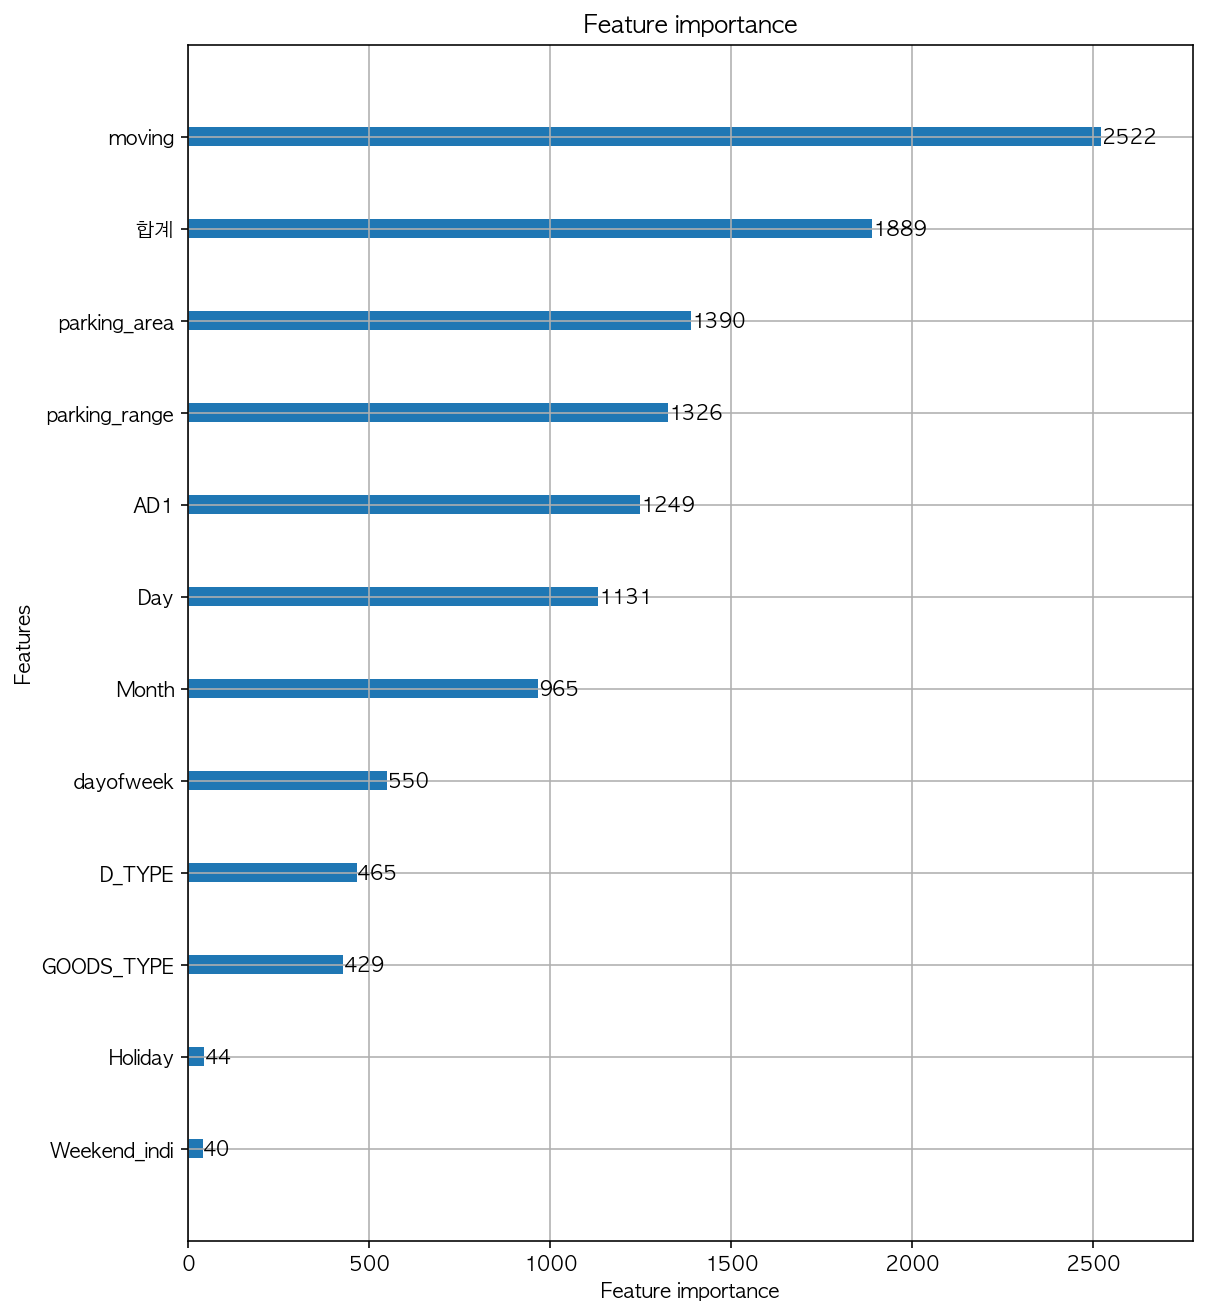

In [21]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(9,11))
plot_importance(lgbr, ax=ax)
plt.savefig('변수의 중요도.png')